In [1]:
import sys
import os
import os.path

import lib.cnn.matnpyio as io
import lib.cnn.cnn as cnn 
import lib.cnn.matnpy as matnpy
import lib.cnn.helpers as hlp

import tensorflow as tf
import numpy as np
from math import ceil

import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import datetime

In [2]:
# lib for the jupyter only
import sklearn.metrics # classification_report , confusion_matrix
import matplotlib.pyplot as plt
from scipy.special import erfinv
from scipy.special import erf
import itertools

for more info on the recall macro, precision macro, f-score, etc :
http://rali.iro.umontreal.ca/rali/sites/default/files/publis/SokolovaLapalme-JIPM09.pdf

In [3]:
# function for the jupyter

def rapport(confusion_matrix):
    """
    This function returns performance measures for the classification tasks 
    """
    dico = {}
    classes = len(confusion_matrix)
    
    if classes == 2 :
        
        tp = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        tn = cm[1][1]
        
        dico['accuracy'] = tp + tn /(tp +fn +fp +tn)
        dico['precision'] = tp/(tp +fp)
        dico['recall'] = tp/(tp + fn) # Sensitivity
        beta = 1
        dico['Fscore1'] = (beta**2 +1)*tp/( (beta**2 +1)*tp + beta**2*fn +fp )
        dico['Specificity'] = tn/ (fp + tn)
        dico['AUC'] = 0.5 *( tp /(tp +fn) + tn/(tn + fp) )
    else:
        fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
        fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
        tp = np.diag(confusion_matrix)
        tn = confusion_matrix.sum() - (fp + fn + tp)

        dico['average_accuracy'] = np.mean( (tp + tn)/(tp + fn + fp + tn))
        dico['error_rate'] = np.mean( (fp + fn)/(tp +fn + fp +tn) )

        #micro


        dico['precision_micro'] = np.sum(tp) / (np.sum(tp) + np.sum(fp))
        dico['recall_micro'] = np.sum(tp) / (np.sum(tp) +np.sum(fn))
        beta = 1
        dico['Fscore1_micro'] = (beta**2+1)*dico['precision_micro'] * dico['recall_micro']/( beta **2 * dico['precision_micro']+dico['recall_micro'])

        # macro

        dico['precision_macro'] = np.mean(  tp/(tp+fp) )
        dico['recall_macro'] = np.mean(  tp/(tp+fn) )
        beta = 1
        dico['Fscore1_macro'] = (beta**2+1)*dico['precision_macro'] * dico['recall_macro']/( beta **2 * dico['precision_macro']+dico['recall_macro'])
    return(dico)

#from scipy.special import erfinv
#from scipy.special import erf

def get_recall_macro(confusion_matrix,  alpha = erf(1/np.sqrt(2)) ):
    """
    This function returns the recall macro*, its error bar for a confidence interval of alpha (default at 68%),
    the accuracy per class, and the number of element of each class.
    
    recall macro is the mean of accuracy per class.
    """
    n_test = np.sum(confusion_matrix, axis = 1)
    
    classes = confusion_matrix.shape[0]
    
    
    #fp = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    fn = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    tp = np.diag(confusion_matrix)
    #tn = confusion_matrix.sum() - (fp + fn + tp)
    
    #
    recall_macro_per_class = tp/(tp+fn)
    #print(recall_macro_per_class)
    #
    recall_macro = np.mean(recall_macro_per_class)
    
    # l'écart-type théorique du recall macro, soit un interval de confiance de 0.68 = erf( 1/np.sqrt(2)) --> 1 fois l'écart-type
    error_bar = np.sqrt(2) * erfinv(alpha) *np.sqrt( np.sum(recall_macro_per_class * (1 - recall_macro_per_class)/n_test) ) /classes 
    
    return(recall_macro, error_bar, recall_macro_per_class, n_test )

#import itertools
def plot_confusion_matrix(cm, classes_names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes_names))
    plt.xticks(tick_marks, classes_names, rotation=45)
    plt.yticks(tick_marks, classes_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

In [4]:
################################################
#                    PARAMS                    #
################################################

#################
### base path ###
#################

base_path = '/media/rudy/disk2/lucy/'

###################
### data params ###
###################

sess_no ='150210'

# path
raw_path = base_path +sess_no+'/session01/'
rinfo_path = base_path +sess_no+'/session01/' + 'recording_info.mat'
#tinfo_path = base_path +sess_no+'/session01/' + 'trial_info.mat'


# params
decode_for = 'stim'
only_correct_trials = True

align_on, from_time, to_time = 'sample', 0, 500 
lowcut, highcut, order = 80, 300, 3

#choose electrode or cortex, comment one/decomment one
#target_areas = ['V1']
target_cortex = 'Visual'
target_areas = io.get_area_cortex(rinfo_path, target_cortex, unique = True)

# either the data must be normed. 
renorm = True

In [5]:
target_areas

array(['DP', 'MT', 'V1', 'V2', 'V4t', 'V6A'], dtype='<U6')

In [6]:
##################################################
#                 CNN PARAMS                     #
##################################################


if decode_for == 'stim':

    # hyper params
    n_iterations = 100
    size_of_batches = 50
    dist = 'random_normal'
    batch_norm = 'renorm'  # 'after'
    nonlin = 'elu'
    normalized_weights = True
    learning_rate = 1e-5
    l2_regularization_penalty = 5
    keep_prob_train = .5
    
    # layer dimensions
    n_layers = 7
    patch_dim = [1, 5]  # 1xN patch
    pool_dim = [1, 2]
    in1, out1 = 1, 3
    in2, out2 = 3, 6
    in3, out3 = 6, 12
    in4, out4 = 12, 36
    in5, out5 = 36, 72
    in6, out6 = 72, 256
    in7, out7 = 256, 500
    in8, out8 = 500, 1000
    fc_units = 200

else:
    
    # hyper params
    n_iterations = 100
    size_of_batches = 50
    dist = 'random_normal'
    batch_norm = 'after'
    nonlin = 'elu'
    normalized_weights = True
    learning_rate = 1e-5
    l2_regularization_penalty = 20
    keep_prob_train = .1
    
    # layer dimensions
    n_layers = 6
    patch_dim = [1, 5]  # 1xN patch
    pool_dim = [1, 2]
    in1, out1 = 1, 3
    in2, out2 = 3, 6
    in3, out3 = 6, 12
    in4, out4 = 12, 36
    in5, out5 = 36, 72
    in6, out6 = 72, 256
    in7, out7 = 256, 500
    in8, out8 = 500, 1000
    fc_units = 200
    
    
channels_in = [in1, in2, in3, in4, in5, in6, in7, in8][:n_layers]
channels_out = [out1, out2, out3, out4, out5, out6, out7, out8][:n_layers]


##################################################
#                 TESTING PARAMS                 #
##################################################

# one_training (stratify)
train_size = .8
test_size = .2

# k_fold (stratify)
n_splits = 5 

# seed for random split
seed = 8392 #np.random.randint(1,10000)

# Auto-define number of classes
classes = 2 if decode_for == 'resp' else 5

In [7]:
##################################################
#                    GET DATA                    #
##################################################

data = matnpy.get_subset_by_areas(sess_no, raw_path,
                         align_on, from_time, to_time, 
                         lowcut, highcut, 
                         target_areas,
                         epsillon = 10, order= 3,
                         only_correct_trials = only_correct_trials, renorm = renorm, elec_type = 'grid')

n_chans = data.shape[1]
samples_per_trial = data.shape[2]

targets = io.get_targets(decode_for, raw_path, n_chans, elec_type='grid',
                         only_correct_trials=only_correct_trials,
                         onehot=True)

15021001.0001.mat
15021001.0002.mat
15021001.0003.mat
15021001.0004.mat
15021001.0005.mat
15021001.0006.mat
15021001.0007.mat
15021001.0008.mat
15021001.0009.mat
15021001.0010.mat
15021001.0011.mat
15021001.0012.mat
15021001.0013.mat
15021001.0014.mat
15021001.0015.mat
15021001.0016.mat
15021001.0017.mat
15021001.0018.mat
15021001.0019.mat
15021001.0020.mat
15021001.0021.mat
15021001.0022.mat
15021001.0023.mat
15021001.0024.mat
15021001.0025.mat
15021001.0026.mat
15021001.0027.mat
15021001.0028.mat
15021001.0029.mat
15021001.0030.mat
15021001.0031.mat
15021001.0032.mat
15021001.0033.mat
15021001.0034.mat
15021001.0035.mat
15021001.0036.mat
15021001.0037.mat
15021001.0038.mat
15021001.0039.mat
15021001.0040.mat
15021001.0041.mat
15021001.0042.mat
15021001.0043.mat
15021001.0044.mat
15021001.0045.mat
15021001.0046.mat
15021001.0047.mat
15021001.0048.mat
15021001.0049.mat
15021001.0050.mat
15021001.0051.mat
15021001.0052.mat
15021001.0053.mat
15021001.0054.mat
15021001.0055.mat
15021001.0

15021001.0456.mat
15021001.0457.mat
15021001.0458.mat
15021001.0459.mat
15021001.0460.mat
15021001.0461.mat
15021001.0462.mat
15021001.0463.mat
15021001.0464.mat
15021001.0465.mat
15021001.0466.mat
15021001.0467.mat
15021001.0468.mat
15021001.0469.mat
15021001.0470.mat
15021001.0471.mat
15021001.0472.mat
15021001.0473.mat
15021001.0474.mat
15021001.0475.mat
15021001.0476.mat
15021001.0477.mat
15021001.0478.mat
15021001.0479.mat
15021001.0480.mat
15021001.0481.mat
15021001.0482.mat
15021001.0483.mat
15021001.0484.mat
15021001.0485.mat
15021001.0486.mat
15021001.0487.mat
15021001.0488.mat
15021001.0489.mat
15021001.0490.mat
15021001.0491.mat
15021001.0492.mat
15021001.0493.mat
15021001.0494.mat
15021001.0495.mat
15021001.0496.mat
15021001.0497.mat
15021001.0498.mat
15021001.0499.mat
15021001.0500.mat
15021001.0501.mat
15021001.0502.mat
15021001.0503.mat
15021001.0504.mat
15021001.0505.mat
15021001.0506.mat
15021001.0507.mat
15021001.0508.mat
15021001.0509.mat
15021001.0510.mat
15021001.0

15021001.0912.mat
15021001.0913.mat
15021001.0914.mat
15021001.0915.mat
15021001.0916.mat
15021001.0917.mat
15021001.0918.mat
15021001.0919.mat
15021001.0920.mat
15021001.0921.mat
15021001.0922.mat
15021001.0923.mat
15021001.0924.mat
15021001.0925.mat
15021001.0926.mat
15021001.0927.mat
15021001.0928.mat
15021001.0929.mat
15021001.0930.mat
15021001.0931.mat
15021001.0932.mat
15021001.0933.mat
15021001.0934.mat
15021001.0935.mat
15021001.0936.mat
15021001.0937.mat
15021001.0938.mat
15021001.0939.mat
15021001.0940.mat
15021001.0941.mat
15021001.0942.mat
15021001.0943.mat
15021001.0944.mat
15021001.0945.mat
15021001.0946.mat
15021001.0947.mat
15021001.0948.mat
15021001.0949.mat
15021001.0950.mat
15021001.0951.mat
15021001.0952.mat
15021001.0953.mat
15021001.0954.mat
15021001.0955.mat
15021001.0956.mat
15021001.0957.mat
15021001.0958.mat
15021001.0959.mat
15021001.0960.mat
15021001.0961.mat
15021001.0962.mat
15021001.0963.mat
15021001.0964.mat
15021001.0965.mat
15021001.0966.mat
15021001.0

In [8]:
data.shape

(531, 28, 500)

In [9]:
##################################################
#                   CREATE CNN                   #
##################################################


##########
# LAYERS #
##########

# placeholders
x_ = tf.placeholder(tf.float32, shape=[
        None, n_chans, samples_per_trial
        ])
y_ = tf.placeholder(tf.float32, shape=[None, classes])
training = tf.placeholder_with_default(True, shape=())
keep_prob = tf.placeholder(tf.float32)

# Network
out, weights = cnn.create_network(
        n_layers=n_layers, 
        x_in=x_,
        n_in=channels_in, 
        n_out=channels_out, 
        patch_dim=patch_dim,
        pool_dim=pool_dim,
        training=training, 
        n_chans=n_chans,
        n_samples=samples_per_trial,
        weights_dist=dist, 
        normalized_weights=normalized_weights,
        nonlin=nonlin,
        bn=True)


###################
# FULLY-CONNECTED #
###################

# Fully-connected layer (BN)
fc1, weights[n_layers] = cnn.fully_connected(out, 
            bn=True, 
            units=fc_units,
            training=training,
            nonlin=nonlin,
            weights_dist=dist,
            normalized_weights=normalized_weights)


###################
# DROPOUT/READOUT #
###################

# Dropout (BN)
fc1_drop = tf.nn.dropout(fc1, keep_prob)

# Readout
weights[n_layers+1] = cnn.init_weights([fc_units, classes])
y_conv = tf.matmul(fc1_drop, weights[n_layers+1])
weights_shape = [tf.shape(el) for el in weights.values()]


#############
# OPTIMIZER #
#############

# Loss
loss = cnn.l2_loss(weights, 
                   l2_regularization_penalty, 
                   y_, 
                   y_conv, 
                   'loss')

# Optimizer

train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [10]:
##################################################
#             TRAIN AND TEST                     #
##################################################

# SPLIT TRAIN AND TEST

# split into train and test
indices = np.arange(data.shape[0])
train, test, train_labels, test_labels, idx_train, idx_test = (
        train_test_split(
            data, 
            targets, 
            indices,
            test_size=test_size, 
            random_state=seed,
            stratify = np.argmax(targets, axis = 1)
            )
        ) 
        
ind_test = hlp.subset_test(test_labels, classes) # for a test accuracy on a balanced base


############
# TRAINING #
############

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Number of batches to train on
    for i in range(n_iterations):
        ind_train = hlp.subset_train(train_labels, classes, size_of_batches)

        # Every n iterations, print training accuracy
        if i % 10 == 0:
            train_accuracy = accuracy.eval(feed_dict={
                    x_: train[ind_train,:,:],
                    y_: train_labels[ind_train,:],
                    keep_prob: 1.0
                    })
            print('step %d, training accuracy: %g' % (
                    i, train_accuracy))
  
        # Training
        curr_x = train[ind_train,:,:]
        curr_y = train_labels[ind_train,:]
        train_step.run(feed_dict={
                x_: curr_x,
                y_: curr_y,
                keep_prob: keep_prob_train
                })




    # Print test accuracy on a balanced base
    curr_x_test = test[ind_test,:,:]
    curr_y_test = test_labels[ind_test,:]
    
    acc_cnn = accuracy.eval(feed_dict={
            x_: curr_x_test,
            y_: curr_y_test,
            keep_prob: 1.0
            })
    
    # result on the base test
    curr_x_test = test[:,:,:]
    curr_y_test = test_labels[:,:]
    
    curr_y_predict = y_conv.eval(feed_dict={
                    x_: curr_x_test,
                    y_: curr_y_test,
                    keep_prob: 1.0
            })
    
    y_true = np.argmax(curr_y_test, axis = 1)
    y_pred = np.argmax(curr_y_predict, axis = 1) 
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    # recall macro
    recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix)
    
       
    print('test accuracy: CNN %g ' % (acc_cnn) ) 
    print('test recall_macro: %g +- %g' % (recall_macro, error_bar))

    # Get size of weights
    size_weights = sess.run(weights_shape)
    

step 0, training accuracy: 0.12
step 10, training accuracy: 0.82
step 20, training accuracy: 0.94
step 30, training accuracy: 0.98
step 40, training accuracy: 1
step 50, training accuracy: 1
step 60, training accuracy: 1
step 70, training accuracy: 1
step 80, training accuracy: 1
step 90, training accuracy: 1
test accuracy: CNN 0.877778 


In [11]:
print(train.shape)
print(test.shape)
print(classes)

(424, 28, 500)
(107, 28, 500)
5


In [12]:
seed

8392

confusion matrix :
[[19  0  1  0  1]
 [ 0 17  0  0  1]
 [ 1  0 14  2  2]
 [ 0  0  0 24  0]
 [ 0  4  4  0 17]]
Normalized confusion matrix


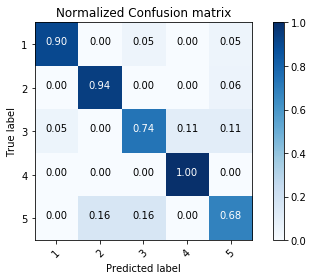


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
85.32  +-  3.22  %

Report classifier :
             precision    recall  f1-score   support

          0       0.95      0.90      0.93        21
          1       0.81      0.94      0.87        18
          2       0.74      0.74      0.74        19
          3       0.92      1.00      0.96        24
          4       0.81      0.68      0.74        25

avg / total       0.85      0.85      0.85       107

average_accuracy , :  0.9401869158878504
error_rate , :  0.05981308411214953
precision_micro , :  0.8504672897196262
recall_micro , :  0.8504672897196262
Fscore1_micro , :  0.850467289719626
precision_macro , :  0.8457933294775399
recall_macro , :  0.8532096908939014
Fscore1_macro , :  0.8494853235115364


In [13]:

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix)

classif_report_per_class = sklearn.metrics.classification_report(y_true, y_pred)
classif_report = rapport(confusion_matrix) 


print('confusion matrix :')
print(confusion_matrix)

plt.figure()
classes_names = np.arange(1,classes+1,1)
plot_confusion_matrix(confusion_matrix, classes_names, normalize=True, title='Normalized Confusion matrix')
plt.show()

print('\nrecall_macro (moyenne des taux de réussite de chaque classe):')
print('average per-class effectiveness of a classifier to identify class labels')
print( round(100* recall_macro, 2), ' +- ', round(100*error_bar, 2), ' %')

print('\nReport classifier :')
print(classif_report_per_class)

for key in classif_report:
    print(key,', : ',classif_report[key] )
#print(classif_report)

http://rali.iro.umontreal.ca/rali/sites/default/files/publis/SokolovaLapalme-JIPM09.pdf

In [14]:
dico = rapport(sklearn.metrics.confusion_matrix(y_true, y_pred))

In [15]:
dico

{'average_accuracy': 0.9401869158878504,
 'error_rate': 0.05981308411214953,
 'precision_micro': 0.8504672897196262,
 'recall_micro': 0.8504672897196262,
 'Fscore1_micro': 0.850467289719626,
 'precision_macro': 0.8457933294775399,
 'recall_macro': 0.8532096908939014,
 'Fscore1_macro': 0.8494853235115364}

# K-FOLD (stratifed)


In [19]:
kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=seed)

dico_fold = {}


cross_validation_i = 0
for idx_train, idx_test in kf.split(data, np.argmax(targets[:,:], axis=1)):    

    cross_validation_i += 1
    print('####################################')
    print('        FOLD NUM   ', cross_validation_i, '/',n_splits)
    print('####################################')
    
    ##################################################
    #             TRAIN AND TEST                     #
    ##################################################

    # SPLIT TRAIN AND TEST

    
    train = data[idx_train]
    test = data[idx_test]
    
    train_labels = targets[idx_train]
    test_labels = targets[idx_test]
    
    ind_test = hlp.subset_test(test_labels, classes) # for a test accuracy on a balanced base


    ############
    # TRAINING #
    ############

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        # Number of batches to train on
        for i in range(n_iterations):
            ind_train = hlp.subset_train(train_labels, classes, size_of_batches)

            # Every n iterations, print training accuracy
            if i % 10 == 0:
                train_accuracy = accuracy.eval(feed_dict={
                        x_: train[ind_train,:,:],
                        y_: train_labels[ind_train,:],
                        keep_prob: 1.0
                        })
                print('step %d, training accuracy: %g' % (
                        i, train_accuracy))

            # Training
            curr_x = train[ind_train,:,:]
            curr_y = train_labels[ind_train,:]
            train_step.run(feed_dict={
                    x_: curr_x,
                    y_: curr_y,
                    keep_prob: keep_prob_train
                    })




        # Print test accuracy on a balanced base
        curr_x_test = test[ind_test,:,:]
        curr_y_test = test_labels[ind_test,:]

        acc_cnn = accuracy.eval(feed_dict={
                x_: curr_x_test,
                y_: curr_y_test,
                keep_prob: 1.0
                })

        # result on the base test
        curr_x_test = test[:,:,:]
        curr_y_test = test_labels[:,:]

        curr_y_predict = y_conv.eval(feed_dict={
                        x_: curr_x_test,
                        y_: curr_y_test,
                        keep_prob: 1.0
                })
        
        # save result #
        dico_fold[cross_validation_i] = {}
        dico_fold[cross_validation_i]['curr_y_test'] = curr_y_test
        dico_fold[cross_validation_i]['curr_y_predict'] = curr_y_predict
        
        y_true = np.argmax(curr_y_test, axis = 1)
        y_pred = np.argmax(curr_y_predict, axis = 1) 
        
        confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        
        # recall macro
        recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix)

#         y_true = np.argmax(curr_y_test, axis = 1)
#         y_pred = np.argmax(curr_y_predict, axis = 1) 


        print('test accuracy: CNN %g ' % (acc_cnn) ) 
        print('test recall_macro: %g +- %g' % (recall_macro, error_bar))

        # Get size of weights
        size_weights = sess.run(weights_shape)

    
    
    
    

####################################
         NUMERO    1 / 5
####################################
step 0, training accuracy: 0.24
step 10, training accuracy: 0.84
step 20, training accuracy: 0.98
step 30, training accuracy: 0.98
step 40, training accuracy: 0.98
step 50, training accuracy: 1
step 60, training accuracy: 1
step 70, training accuracy: 1
step 80, training accuracy: 1
step 90, training accuracy: 1
test accuracy: CNN 0.789474 
test recall_macro: 0.788591 +- 0.0378219
####################################
         NUMERO    2 / 5
####################################
step 0, training accuracy: 0.22
step 10, training accuracy: 0.92
step 20, training accuracy: 0.98
step 30, training accuracy: 0.98
step 40, training accuracy: 0.98
step 50, training accuracy: 1
step 60, training accuracy: 1
step 70, training accuracy: 1
step 80, training accuracy: 1
step 90, training accuracy: 1
test accuracy: CNN 0.844444 
test recall_macro: 0.858035 +- 0.0322401
##################################



k-Fold num° 1


confusion matrix :
[[16  0  2  1  2]
 [ 0 16  0  0  3]
 [ 3  0 11  2  3]
 [ 0  0  0 24  0]
 [ 1  4  1  0 19]]
Normalized confusion matrix


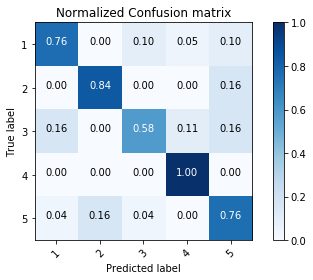


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
78.86  +-  3.78  %

Report classifier :
             precision    recall  f1-score   support

          0       0.80      0.76      0.78        21
          1       0.80      0.84      0.82        19
          2       0.79      0.58      0.67        19
          3       0.89      1.00      0.94        24
          4       0.70      0.76      0.73        25

avg / total       0.79      0.80      0.79       108

average_accuracy  :  0.9185185185185185
error_rate  :  0.08148148148148149
precision_micro  :  0.7962962962962963
recall_micro  :  0.7962962962962963
Fscore1_micro  :  0.7962962962962963
precision_macro  :  0.7956613756613756
recall_macro  :  0.7885914786967418
Fscore1_macro  :  0.7921106520952541


k-Fold num° 2


confusion matrix :
[[21  0  0  0  0]
 [ 0 15  1  0  2]
 [ 3  0 14  0  2]
 [ 0  0  0 24  0]
 [ 1  4  1  1 18]]
Normalized confusion ma

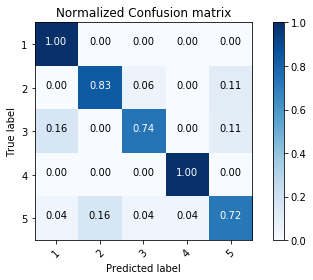


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
85.8  +-  3.22  %

Report classifier :
             precision    recall  f1-score   support

          0       0.84      1.00      0.91        21
          1       0.79      0.83      0.81        18
          2       0.88      0.74      0.80        19
          3       0.96      1.00      0.98        24
          4       0.82      0.72      0.77        25

avg / total       0.86      0.86      0.86       107

average_accuracy  :  0.9439252336448598
error_rate  :  0.05607476635514018
precision_micro  :  0.8598130841121495
recall_micro  :  0.8598130841121495
Fscore1_micro  :  0.8598130841121495
precision_macro  :  0.8565311004784689
recall_macro  :  0.8580350877192983
Fscore1_macro  :  0.8572824344633337


k-Fold num° 3


confusion matrix :
[[18  0  1  2  0]
 [ 0 16  0  0  2]
 [ 4  0 10  4  1]
 [ 0  0  0 23  0]
 [ 0  1  1  1 22]]
Normalized confusion mat

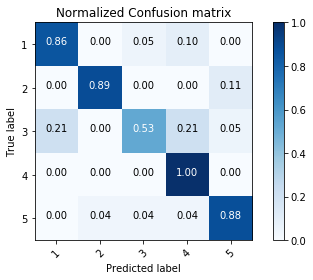


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
83.05  +-  3.39  %

Report classifier :
             precision    recall  f1-score   support

          0       0.82      0.86      0.84        21
          1       0.94      0.89      0.91        18
          2       0.83      0.53      0.65        19
          3       0.77      1.00      0.87        23
          4       0.88      0.88      0.88        25

avg / total       0.85      0.84      0.83       106

average_accuracy  :  0.9358490566037736
error_rate  :  0.06415094339622641
precision_micro  :  0.839622641509434
recall_micro  :  0.839622641509434
Fscore1_micro  :  0.839622641509434
precision_macro  :  0.8478716577540106
recall_macro  :  0.830469507101086
Fscore1_macro  :  0.8390803639267784


k-Fold num° 4


confusion matrix :
[[18  0  2  1  0]
 [ 0 18  0  0  0]
 [ 1  1 12  0  4]
 [ 0  0  0 23  0]
 [ 1  5  0  1 18]]
Normalized confusion matrix

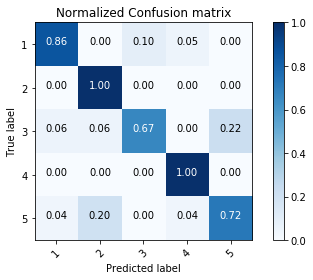


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
84.88  +-  3.24  %

Report classifier :
             precision    recall  f1-score   support

          0       0.90      0.86      0.88        21
          1       0.75      1.00      0.86        18
          2       0.86      0.67      0.75        18
          3       0.92      1.00      0.96        23
          4       0.82      0.72      0.77        25

avg / total       0.85      0.85      0.84       105

average_accuracy  :  0.9390476190476191
error_rate  :  0.06095238095238096
precision_micro  :  0.8476190476190476
recall_micro  :  0.8476190476190476
Fscore1_micro  :  0.8476190476190476
precision_macro  :  0.8490649350649351
recall_macro  :  0.8487619047619047
Fscore1_macro  :  0.8489133928708021


k-Fold num° 5


confusion matrix :
[[19  0  2  0  0]
 [ 0 17  0  0  1]
 [ 3  0 13  1  1]
 [ 0  0  0 23  0]
 [ 0  2  0  0 23]]
Normalized confusion ma

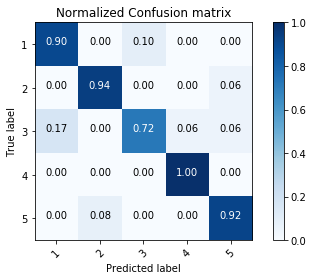


recall_macro (moyenne des taux de réussite de chaque classe):
average per-class effectiveness of a classifier to identify class labels
89.83  +-  2.91  %

Report classifier :
             precision    recall  f1-score   support

          0       0.86      0.90      0.88        21
          1       0.89      0.94      0.92        18
          2       0.87      0.72      0.79        18
          3       0.96      1.00      0.98        23
          4       0.92      0.92      0.92        25

avg / total       0.90      0.90      0.90       105

average_accuracy  :  0.9619047619047618
error_rate  :  0.03809523809523809
precision_micro  :  0.9047619047619048
recall_micro  :  0.9047619047619048
Fscore1_micro  :  0.9047619047619048
precision_macro  :  0.9006746411483254
recall_macro  :  0.8982857142857144
Fscore1_macro  :  0.8994785915309937


In [20]:
for key in dico_fold.keys():
        
    print('\n')
    
    print('k-Fold num°', key)
    print('\n')
    curr_y_test = dico_fold[key]['curr_y_test']
    curr_y_predict = dico_fold[key]['curr_y_predict']
    
    y_true = np.argmax(curr_y_test, axis = 1)
    y_pred = np.argmax(curr_y_predict, axis = 1) 
       
    
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

    recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix)

    classif_report_per_class = sklearn.metrics.classification_report(y_true, y_pred)
    classif_report = rapport(confusion_matrix) 


    print('confusion matrix :')
    print(confusion_matrix)
    plt.figure()
    classes_names = np.arange(1,classes+1,1)
    plot_confusion_matrix(confusion_matrix, classes_names, normalize=True, title='Normalized Confusion matrix')
    plt.show()

    print('\nrecall_macro (moyenne des taux de réussite de chaque classe):')
    print('average per-class effectiveness of a classifier to identify class labels')
    print( round(100* recall_macro, 2), ' +- ', round(100*error_bar, 2), ' %')

    print('\nReport classifier :')
    print(classif_report_per_class)

    for key in classif_report:
        print(key,' : ',classif_report[key] )
    
    #print(classif_report)


In [21]:
### mean on k_fold result
recall_macro_per_kfold = np.zeros( (n_splits) )
error_bar_per_kfold = np.zeros( (n_splits) )
for key in dico_fold.keys():
    
    curr_y_test = dico_fold[key]['curr_y_test']
    curr_y_predict = dico_fold[key]['curr_y_predict']
    
    y_true = np.argmax(curr_y_test, axis = 1)
    y_pred = np.argmax(curr_y_predict, axis = 1) 
    
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
    
    recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix)
    
    recall_macro_per_kfold[key-1] = recall_macro # key start at 1
    error_bar_per_kfold[key - 1] = error_bar
    
print('recall macro sur chaque k_fold')
print(recall_macro_per_kfold )
    
print('\nMoyenne')
recall_macro_mean = np.mean(recall_macro_per_kfold)

print( round( 100 *recall_macro_mean, 1) )

print("\nBarre d'erreur")
error_bar = np.sqrt( np.sum( error_bar_per_kfold**2) )/classes


print( round(100 *error_bar, 2))


    

    
    

recall macro sur chaque k_fold
[0.78859148 0.85803509 0.83046951 0.8487619  0.89828571]

Moyenne
84.5

Barre d'erreur
1.48


In [22]:
np.std(recall_macro_per_kfold)*100/np.sqrt(5)

1.6020415267085943

In [23]:
classes

5

In [24]:
### sum then result

In [25]:
confusion_matrix = []
for key in dico_fold.keys():

    curr_y_test = dico_fold[key]['curr_y_test']
    curr_y_predict = dico_fold[key]['curr_y_predict']
    
    y_true = np.argmax(curr_y_test, axis = 1)
    y_pred = np.argmax(curr_y_predict, axis = 1) 
       
    
    confusion_matrix.append( sklearn.metrics.confusion_matrix(y_true, y_pred))

confusion_matrix = np.array(confusion_matrix)
confusion_matrix_all = np.sum(confusion_matrix, axis = 0)
recall_macro, error_bar, recall_macro_per_class, n_test = get_recall_macro(confusion_matrix_all)

print('\nMoyenne')
print(recall_macro)
print('\nError bar')
print(round(100 *error_bar, 2))


Moyenne
0.8444901335223916

Error bar
1.52
